In [30]:
# activate env using
## source path_to_env/bin/activate

In [31]:
import seaborn as sns
import pandas as pd
import numpy as np
import sys

import requests
import os
import io

# https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/truth_utils/_utils.py

'''
    Download raw truth csv from a given url and convert into pandas dataframe
'''
def get_raw_truth_df(url):
    url_req = requests.get(url).content
    df      = pd.read_csv(io.StringIO(url_req.decode('utf-8')))
    return df

URL_DEATHS = "https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Deaths.csv"
URL_CASES  = "https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Cases.csv"
URL_HOSP   = "https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Hospitalizations.csv"
URL_LOC    = "https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-locations/locations.csv"

df_cases  = get_raw_truth_df(URL_CASES)
df_deaths = get_raw_truth_df(URL_DEATHS)
df_hosps  = get_raw_truth_df(URL_HOSP)
df_loc    = pd.read_csv(os.path.join("data", "locations_usa.csv"))


/Users/chaosdonkey06/Dropbox/My Mac (Jaimes-MacBook-Pro.local)/Desktop/Forecasting/frcstng_experiments/pinn_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [33]:
STATE_USE = "NY"

loc_df    = df_loc[df_loc.abbreviation==STATE_USE]
cases     = df_cases[df_cases.location==loc_df.location.values[0]].set_index('location_name').join(df_loc.set_index('location_name'), how='left', lsuffix='test').rename(columns={"value": "cases"})
deaths    = df_deaths[df_deaths.location==loc_df.location.values[0]].set_index('location_name').join(df_loc.set_index('location_name'), how='left', lsuffix='test').rename(columns={"value": "deaths"})
#hosp      = df_hosps[df_hosps.location==loc_df.location.values[0]].set_index('location_name').join(df_loc.set_index('location_name'), how='left', lsuffix='test').rename(columns={"value": "hospitalizations"})

# merge incident data in one dataframe
data_df                            = pd.merge(left=cases, right=deaths, how="inner")[["date", "abbreviation", "cases", "deaths", "population"]]
#data_df                            = pd.merge(left=data_df, right=hosp, how="inner")[["date", "abbreviation", "cases", "deaths", "hospitalizations", "population"]]
data_df                            = data_df.set_index("date")
data_df["cases_smooth"]            = data_df["cases"].rolling(window=7).mean().fillna(0)
data_df["deaths_smooth"]           = data_df["deaths"].rolling(window=7).mean().fillna(0)
#data_df["hospitalizations_smooth"] = data_df["hospitalizations"].rolling(window=7).mean().fillna(0)
data_df                            = data_df.reset_index()

data_df["date"] = pd.to_datetime(data_df["date"])
data_df = data_df.set_index("date")

num_days = 500
data_df = data_df.iloc[:num_days]
data_df

,abbreviation,cases,deaths,population,cases_smooth,deaths_smooth
date,,,,,,
2020-01-22,NY,0,0,19453561.0,0.000000,0.000000
2020-01-23,NY,0,0,19453561.0,0.000000,0.000000
2020-01-24,NY,0,0,19453561.0,0.000000,0.000000
2020-01-25,NY,0,0,19453561.0,0.000000,0.000000
2020-01-26,NY,0,0,19453561.0,0.000000,0.000000
...,...,...,...,...,...,...
2021-05-31,NY,529,18,19453561.0,874.857143,20.000000
2021-06-01,NY,465,25,19453561.0,809.857143,21.142857
2021-06-02,NY,400,9,19453561.0,738.714286,18.571429


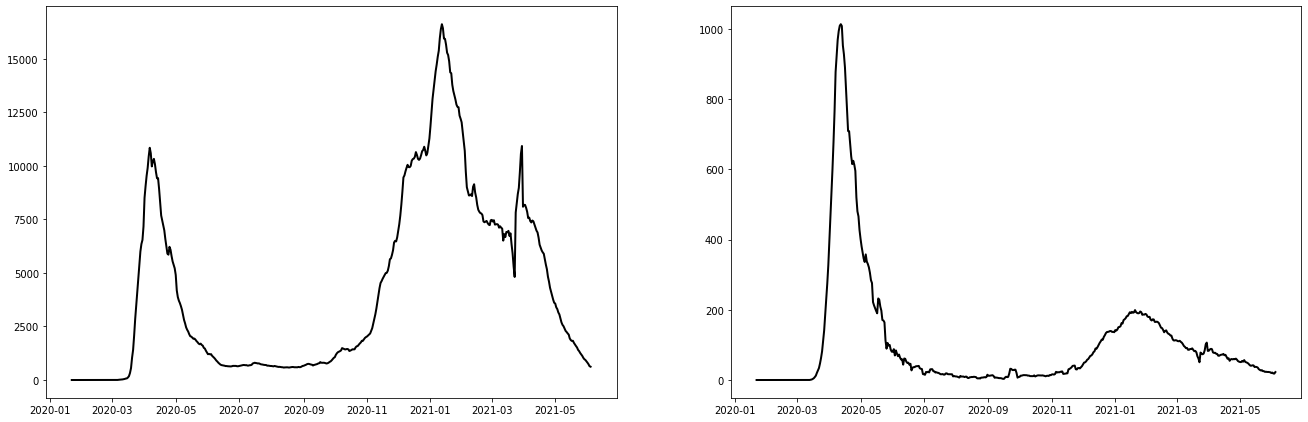

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(22.5, 7.2), sharex=True)

ax[0].plot(data_df.index.values, data_df["cases_smooth"], lw=2, c="k")
ax[1].plot(data_df.index.values, data_df["deaths_smooth"], lw=2, c="k")
#ax[2].plot(data_df.index.values, data_df["hospitalizations_smooth"], lw=2, c="k")


In [35]:
from scipy.interpolate import griddata
import tensorflow as tf
import scipy.io
import math
import time

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
#from pyDOE import lhs
import datetime

start_time = time.time()


In [36]:
#%%

class PhysicsInformedNN:
    #Initialize the class
    def __init__(self, t_train, I_new_train, D_new_train, H_new_train,
                 I_sum_train, D_sum_train, H_sum_train, U0, t_f, lb, ub, N,
                 layers, layers_beta, layers_p, layers_q, sf):

        self.N           = N
        self.sf          = sf

        #Data for training
        self.t_train     = t_train
        self.I_new_train = I_new_train
        self.D_new_train = D_new_train
        self.H_new_train = H_new_train
        self.I_sum_train = I_sum_train
        self.D_sum_train = D_sum_train
        self.H_sum_train = H_sum_train
        self.S0          = U0[0]
        self.E0          = U0[1]
        self.I0          = U0[2]
        self.J0          = U0[3]
        self.D0          = U0[4]
        self.H0          = U0[5]
        self.R0          = U0[6]
        self.t_f         = t_f

        #Time division s
        self.M = len(t_f)-1
        self.tau = t_f[1]-t_f[0]

        #Bounds
        self.lb = lb
        self.ub = ub

        # initialize NN
        self.weights,      self.biases      = self.initialize_NN(layers)
        self.weights_beta, self.biases_beta = self.initialize_NN(layers_beta)
        self.weights_p,    self.biases_p    = self.initialize_NN(layers_p)
        self.weights_q,    self.biases_q    = self.initialize_NN(layers_q)

       #Fixed parameters
        self.N = N
        self.delta  = tf.Variable(0.6,     dtype=tf.float64, trainable=False)
        self.gamma  = tf.Variable(1.0/6.0, dtype=tf.float64, trainable=False)
        self.gammaA = tf.Variable(1.0/6.0, dtype=tf.float64, trainable=False)
        # self.gamma = tf.Variable(1.0/7.0,dtype=tf.float64,trainable=False)
        # self.gammaA = tf.Variable(1.0/7.0,dtype=tf.float64,trainable=False)
        self.alpha  = tf.Variable(1.0/5.2,  dtype=tf.float64,  trainable=False)
        self.alpha1 = tf.Variable(1.0/2.9,  dtype=tf.float64,  trainable=False)
        self.alpha2 = tf.Variable(1.0/2.3,  dtype=tf.float64,  trainable=False)
        self.eps1   = tf.Variable(0.75,     dtype=tf.float64,  trainable=False)
        self.eps2   = tf.Variable(0.0,      dtype=tf.float64,  trainable=False)
        self.phiD   = tf.Variable(1.0/15.0, dtype=tf.float64,  trainable=False)
        self.phiR   = tf.Variable(1.0/7.5,  dtype=tf.float64,  trainable=False)
        # self.phiD = tf.Variable(1.0/17.0,dtype=tf.float64,trainable=False)
        # self.phiR = tf.Variable(1.0/4.0,dtype=tf.float64,trainable=False)

       # tf placeholders and graph
        self.sess   = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        self.saver  = tf.train.Saver()

        # placeholders for inputs
        self.t_u     = tf.placeholder(tf.float64, shape=[None, self.t_train.shape[1]])
        self.I_new_u = tf.placeholder(tf.float64, shape=[None, self.I_new_train.shape[1]])
        self.D_new_u = tf.placeholder(tf.float64, shape=[None, self.D_new_train.shape[1]])
        self.H_new_u = tf.placeholder(tf.float64, shape=[None, self.H_new_train.shape[1]])
        self.I_sum_u = tf.placeholder(tf.float64, shape=[None, self.I_sum_train.shape[1]])
        self.D_sum_u = tf.placeholder(tf.float64, shape=[None, self.D_sum_train.shape[1]])
        self.H_sum_u = tf.placeholder(tf.float64, shape=[None, self.H_sum_train.shape[1]])
        self.S0_u    = tf.placeholder(tf.float64, shape=[None, self.S0.shape[1]])
        self.E0_u    = tf.placeholder(tf.float64, shape=[None, self.E0.shape[1]])
        self.I0_u    = tf.placeholder(tf.float64, shape=[None, self.I0.shape[1]])
        self.J0_u    = tf.placeholder(tf.float64, shape=[None, self.J0.shape[1]])
        self.D0_u    = tf.placeholder(tf.float64, shape=[None, self.D0.shape[1]])
        self.H0_u    = tf.placeholder(tf.float64, shape=[None, self.H0.shape[1]])
        self.R0_u    = tf.placeholder(tf.float64, shape=[None, self.R0.shape[1]])
        self.t_tf    = tf.placeholder(tf.float64, shape=[None, self.t_f.shape[1]])

        # physics informed neural networks
        self.S_pred, self.E_pred, self.I_pred, self.J_pred, self.D_pred, self.H_pred, self.R_pred, self.I_sum_pred, self.D_sum_pred, self.H_sum_pred = self.net_u(self.t_u)

        self.BetaI_pred = self.net_BetaI(self.t_u)
        self.p_pred     = self.net_p(self.t_u)
        self.q_pred     = self.net_q(self.t_u)

        self.I_new_pred = self.I_sum_pred[1:,:]-self.I_sum_pred[0:-1,:]
        self.H_new_pred = self.H_sum_pred[1:,:]-self.H_sum_pred[0:-1,:]
        self.D_new_pred = self.D_sum_pred[1:,:]-self.D_sum_pred[0:-1,:]

        self.S0_pred    = self.S_pred[0]
        self.E0_pred    = self.E_pred[0]
        self.I0_pred    = self.I_pred[0]
        self.J0_pred    = self.J_pred[0]
        self.D0_pred    = self.D_pred[0]
        self.H0_pred    = self.H_pred[0]
        self.R0_pred    = self.R_pred[0]

        self.E_f, self.I_f, self.J_f, self.D_f, self.H_f, self.R_f, self.I_sum_f, self.H_sum_f = self.net_f(self.t_tf)

        # loss
        self.lossU0 = tf.reduce_mean(tf.square(self.E0_u - self.E0_pred))   + \
                        tf.reduce_mean(tf.square(self.I0_u - self.I0_pred)) + \
                        tf.reduce_mean(tf.square(self.J0_u - self.J0_pred)) + \
                        tf.reduce_mean(tf.square(self.D0_u - self.D0_pred)) + \
                        tf.reduce_mean(tf.square(self.H0_u - self.H0_pred)) + \
                        tf.reduce_mean(tf.square(self.R0_u - self.R0_pred))
            # tf.reduce_mean(tf.square(self.S0_u - self.S0_pred))

        # self.lossU = tf.reduce_mean(tf.square(self.I_new_u[:-1,:] - self.I_new_pred)) + \
        #     tf.reduce_mean(tf.square(self.D_new_u[:-1,:] - self.D_new_pred)) + \
        #     tf.reduce_mean(tf.square(self.H_new_u[:-1,:] - self.H_new_pred)) + \
        #     tf.reduce_mean(tf.square(self.I_sum_u - self.I_sum_pred)) + \
        #     tf.reduce_mean(tf.square(self.D_sum_u - self.D_sum_pred)) + \
        #     tf.reduce_mean(tf.square(self.H_sum_u - self.H_sum_pred))


        # LOSS ON THE INCIDENCE (OBSERVED), CONSIDER BOTH INCIDENT AND CUMULATIVE CASES
        self.lossU = 120*tf.reduce_mean(tf.square(self.I_new_u[:-1,:] - self.I_new_pred)) + \
                        10*120*tf.reduce_mean(tf.square(self.D_new_u[:-1,:] - self.D_new_pred)) + \
                        3*120*tf.reduce_mean(tf.square(self.H_new_u[:-1,:] - self.H_new_pred)) + \
                        tf.reduce_mean(tf.square(self.I_sum_u - self.I_sum_pred)) + \
                        10*tf.reduce_mean(tf.square(self.D_sum_u - self.D_sum_pred)) + \
                        3*tf.reduce_mean(tf.square(self.H_sum_u - self.H_sum_pred))

        self.lossF = tf.reduce_mean(tf.square(self.E_f)) + tf.reduce_mean(tf.square(self.I_f)) + \
                    tf.reduce_mean(tf.square(self.J_f)) + tf.reduce_mean(tf.square(self.D_f)) + \
                    tf.reduce_mean(tf.square(self.H_f)) + tf.reduce_mean(tf.square(self.R_f)) + \
                    tf.reduce_mean(tf.square(self.I_sum_f)) + tf.reduce_mean(tf.square(self.H_sum_f))

        self.loss = self.lossU0 + self.lossU + self.lossF
        # self.loss = self.lossU + self.lossF

        #Optimizer
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method = 'L-BFGS-B',
                                                                options = {'maxiter': 1000, #50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        init = tf.global_variables_initializer()
        self.sess.run(init)

    #Initialize the nueral network
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]]) # weights for the current layer
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float64), dtype=tf.float64) #biases for the current layer
            weights.append(W)  # save the elements in W to weights (a row vector)
            biases.append(b)   # save the elements in b to biases (a 1Xsum(layers) row vector)
        return weights, biases

    #generating weights
    def xavier_init(self, size):
        #.compat.v1.random.
        in_dim  = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=tf.float64), dtype=tf.float64)

    #Architecture of the neural network
    def neural_net(self, t, weights, biases):

        num_layers = len(weights) + 1

        H = 2.0*(t-self.lb)/(self.ub-self.lb) - 1.0

        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, t):
        SEIJDHR = self.neural_net(t, self.weights, self.biases)
        # SEIJDHR = SEIJDHR**2
        E     = tf.math.maximum(SEIJDHR[:,0:1], 0)
        I     = tf.math.maximum(SEIJDHR[:,1:2], 0)
        J     = tf.math.maximum(SEIJDHR[:,2:3], 0)
        D     = tf.math.maximum(SEIJDHR[:,3:4], 0)
        H     = tf.math.maximum(SEIJDHR[:,4:5], 0)
        R     = tf.math.maximum(SEIJDHR[:,5:6], 0)
        I_sum = tf.math.maximum(SEIJDHR[:,6:7], 0)
        H_sum = tf.math.maximum(SEIJDHR[:,7:8], 0)
        D_sum = tf.math.maximum(D, 0)
        S     = self.N-E-I-J-D-H-R

        return S, E, I, J, D, H, R, I_sum, D_sum, H_sum

    def net_BetaI(self, t):
        BetaI = self.neural_net(t, self.weights_beta, self.biases_beta)
        bound_b = [tf.constant(0.05, dtype=tf.float64), tf.constant(1.0, dtype=tf.float64)]
        return bound_b[0]+(bound_b[1]-bound_b[0])*tf.sigmoid(BetaI)

    def net_p(self, t):
        p = self.neural_net(t, self.weights_p, self.biases_p)
        return tf.sigmoid(p)

    def net_q(self,t):
        q = self.neural_net(t, self.weights_q, self.biases_q)
        return 0.15+(0.6-0.15)*tf.sigmoid(q)
        # return tf.sigmoid(q)

    def net_f(self, t):

        #load fixed parameters
        delta  = self.delta
        eps1   = self.eps1
        eps2   = self.eps2
        alpha  = self.alpha
        gamma  = self.gamma
        gammaA = self.gammaA
        phiD   = self.phiD
        phiR   = self.phiR

        #load time-dependent parameters
        betaI = self.net_BetaI(t)
        p     = self.net_p(t)
        q     = self.net_q(t)

        #Obtain S,E,I,J,D,H,R from Neural network
        S, E, I, J, D, H, R, I_sum, D_sum, H_sum = self.net_u(t)

        #Time derivatives
        E_t     = tf.gradients(E,     t, unconnected_gradients='zero')[0]
        I_t     = tf.gradients(I,     t, unconnected_gradients='zero')[0]
        J_t     = tf.gradients(J,     t, unconnected_gradients='zero')[0]
        D_t     = tf.gradients(D,     t, unconnected_gradients='zero')[0]
        H_t     = tf.gradients(H,     t, unconnected_gradients='zero')[0]
        R_t     = tf.gradients(R,     t, unconnected_gradients='zero')[0]
        I_sum_t = tf.gradients(I_sum, t, unconnected_gradients='zero')[0]
        H_sum_t = tf.gradients(H_sum, t, unconnected_gradients='zero')[0]

        #Residuals
        # VCn     = tf.where(t<300*tf.ones(tf.shape(t), dtype = tf.float64), \
        #               tf.zeros(tf.shape(t), dtype = tf.float64), \
        #                   tf.where(t<350*tf.ones(tf.shape(t), dtype = tf.float64), \
        #                   (t-300)*600, 30000*tf.ones(tf.shape(t), dtype = tf.float64))) # Vaccination

        # VCn     = VCn*self.sf

        f_E     = E_t - (betaI*(I+eps1*J+eps2*H)/self.N)*S + alpha*E
        f_I     = I_t - (delta*alpha)*E + gamma*I
        f_J     = J_t - ((1-delta)*alpha)*E + gammaA*J
        f_D     = D_t - (q*phiD)*H
        f_H     = H_t - (p*gamma)*I + (q*phiD) * H + ((1-q)*phiR) * H
        f_R     = R_t - gammaA*J - ((1-p)*gamma)*I - ((1-q)*phiR)*H     # - VCn*S/self.N
        f_I_sum = I_sum_t - (delta*alpha)*E
        f_H_sum = H_sum_t - (p*gamma)*I


        return f_E, f_I, f_J, f_D, f_H, f_R, f_I_sum, f_H_sum

    def callback(self, loss, lossU0, lossU, lossF):
        total_records_LBFGS.append(np.array([loss, lossU0, lossU, lossF]))
        #print('Loss: %.3e, LossU0: %.3e, LossU: %.3e, LossF: %.3e' % (loss, lossU0, lossU, lossF))

    def train(self, nIter):

        tf_dict = {self.t_u:     self.t_train,     self.t_tf:    self.t_f,
                   self.I_new_u: self.I_new_train, self.D_new_u: self.D_new_train, self.H_new_u: self.H_new_train,
                   self.I_sum_u: self.I_sum_train, self.H_sum_u: self.H_sum_train, self.D_sum_u: self.D_sum_train,
                   self.S0_u:    self.S0,          self.E0_u:    self.E0,          self.I0_u:    self.I0,
                   self.J0_u:    self.J0,          self.D0_u:    self.D0,          self.H0_u:    self.H0,
                   self.R0_u:    self.R0}

        start_time = time.time()
        for it in range(nIter+1):
            self.sess.run(self.train_op_Adam, tf_dict)

            # Print
            if it % 1000 == 0:
                elapsed      = time.time() - start_time
                loss_value   = self.sess.run(self.loss,   tf_dict)
                lossU0_value = self.sess.run(self.lossU0, tf_dict)
                lossU_value  = self.sess.run(self.lossU,  tf_dict)
                lossF_value  = self.sess.run(self.lossF,  tf_dict)
                total_records.append(np.array([it, loss_value, lossU0_value, lossU_value, lossF_value]))
                print('It: %d, Loss: %.3e, LossU0: %.3e, LossU: %.3e, LossF: %.3e, Time: %.2f' %
                      (it, loss_value, lossU0_value, lossU_value, lossF_value, elapsed))
                start_time = time.time()

        if LBFGS:
            self.optimizer.minimize(self.sess,
                                    feed_dict = tf_dict, # Inputs of the minimize operator
                                    fetches = [self.loss, self.lossU0, self.lossU, self.lossF],
                                    loss_callback = self.callback) # Show the results of minimize operator

    def predict(self, t_star):

        tf_dict = {self.t_u: t_star}

        S     = self. sess.run(self.S_pred,     tf_dict)
        E     = self. sess.run(self.E_pred,     tf_dict)
        I     = self. sess.run(self.I_pred,     tf_dict)
        J     = self. sess.run(self.J_pred,     tf_dict)
        D     = self. sess.run(self.D_pred,     tf_dict)
        #H     = self. sess.run(self.H_pred,     tf_dict)
        R     = self. sess.run(self.R_pred,     tf_dict)
        I_sum = self. sess.run(self.I_sum_pred, tf_dict)
        D_sum = self. sess.run(self.D_sum_pred, tf_dict)
        H_sum = self. sess.run(self.H_sum_pred, tf_dict)
        I_new = self. sess.run(self.I_new_pred, tf_dict)
        D_new = self. sess.run(self.D_new_pred, tf_dict)
        #H_new = self. sess.run(self.H_new_pred, tf_dict)
        BetaI = self. sess.run(self.BetaI_pred, tf_dict)
        p     = self. sess.run(self.p_pred,     tf_dict)
        q     = self. sess.run(self.q_pred,     tf_dict)

        #return S, E, I, J, D, H, R, I_new, D_new, H_new, I_sum, D_sum, H_sum, BetaI, p, q
        return S, E, I, J, D, R, I_new, D_new, I_sum, D_sum, BetaI, p, q

In [9]:
#Architecture of of the NN

layers      = [1] + 5*[20] + [8] # The inout is t while the outputs are E, I, J, D, H, R, I_sum, H_sum, D_sum
layers_beta = [1] + 1*[5]  + [1]
layers_p    = [1] + 1*[5]  + [1]
layers_q    = [1] + 1*[5]  + [1]

In [10]:

I_new_star = np.expand_dims(data_df['cases_smooth'].to_numpy(dtype=np.float64), -1)            # [num_days x 1]
D_new_star = np.expand_dims(data_df['deaths_smooth'].to_numpy(dtype=np.float64), -1)           # [num_days x 1]
H_new_star = np.expand_dims(data_df['hospitalizations_smooth'].to_numpy(dtype=np.float64), -1) # [num_days x 1]

I_sum_star = np.cumsum(I_new_star, axis=0)
H_sum_star = np.cumsum(H_new_star, axis=0)
D_sum_star = np.cumsum(D_new_star, axis=0)

t_star     = np.expand_dims(np.arange(len(I_new_star)), -1)

pop          = data_df["population"].values[0]

# Lower and upper bounds
lb         = t_star.min(0)
ub         = t_star.max(0)

# Initial conditions
I0_new     = I_new_star[0:1,:]
D0_new     = D_new_star[0:1,:]
H0_new     = H_new_star[0:1,:]
I0_sum     = I_sum_star[0:1,:]
D0_sum     = D_sum_star[0:1,:]
H0_sum     = H_sum_star[0:1,:]

# Scaling
sf         = 1e-4
N          = pop * sf
I_new_star = I_new_star * sf
H_new_star = H_new_star * sf
D_new_star = D_new_star * sf
I_sum_star = I_sum_star * sf
H_sum_star = H_sum_star * sf
D_sum_star = D_sum_star * sf

# Initial conditions
E0         = I_sum_star[0:1,:]
I0         = I_sum_star[0:1,:]
J0         = E0 - I0
D0         = D_sum_star[0:1,:]
H0         = np.array([[0.0]])
R0         = np.array([[0.0]])
S0         = N - E0 - I0 - J0 - D0 - H0 - R0
S0         = S0.reshape([1,1])
U0         = [S0, E0, I0, J0, D0, H0, R0]


In [11]:
# residual points
N_f         = 3000
t_f         = np.random.uniform(low=lb, high=ub, size=(N_f, 1))

######################################################################
######################## Training and Predicting #####################
######################################################################
t_train     = t_star
I_new_train = I_new_star
D_new_train = D_new_star
H_new_train = H_new_star
I_sum_train = I_sum_star
D_sum_train = D_sum_star
H_sum_train = H_sum_star


In [12]:
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
# Change it to the sample expression as follows.
#init = tf.compat.v1.random.truncated_normal()

In [13]:

# model
total_records       = []
total_records_LBFGS = []
model               = PhysicsInformedNN(t_train, I_new_train, D_new_train, H_new_train, I_sum_train, D_sum_train, H_sum_train, U0, t_f, lb, ub, N, layers, layers_beta, layers_p, layers_q, sf)

# training
LBFGS = True
# LBFGS=False
model.train(20000) # Training with n iterations

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

It: 0, Loss: 1.376e+04, LossU0: 2.709e-02, LossU: 1.376e+04, LossF: 2.136e-03, Time: 2.59
It: 1000, Loss: 9.675e+03, LossU0: 7.402e-03, LossU: 9.675e+03, LossF: 3.256e-03, Time: 29.74
It: 2000, Loss: 7.214e+03, LossU0: 3.409e-05, LossU: 7.214e+03, LossF: 2.375e-02, Time: 543.71
It: 3000, Loss: 5.289e+03, LossU0: 6.432e-08, LossU: 5.289e+03, LossF: 4.916e-02, Time: 931.47
It: 4000, Loss: 3.754e+03, LossU0: 0.000e+00, LossU: 3.753e+03, LossF: 8.290

In [14]:
# dates
dates        = pd.to_datetime(data_df.index.values)

# predict in indicated times
S, E, I, J, D, H, R, I_new, D_new, H_new, I_sum, D_sum, H_sum, BetaI, p, q = model.predict(t_star)

variables_df  = pd.DataFrame(columns=["date", "susceptible", "exposed", "infected", "deaths", "hosp", "recovered", "inf_incidence", "deaths_incidence", "hosp_incidence"]); variables_df["date"]  = dates
parameters_df = pd.DataFrame(columns=["date", "beta", "p", "q"]); parameters_df["date"]  = dates

variables_df["susceptible"] = S
variables_df["exposed"]     = E
variables_df["infected"]    = I
variables_df["deaths"]      = D
variables_df["hosp"]        = H
variables_df["recovered"]   = R

incident_df = pd.DataFrame(columns=["date", "inf_incidence", "deaths_incidence", "hosp_incidence"]); incident_df["date"]  = dates[1:]
incident_df["inf_incidence"]    = I_new
incident_df["deaths_incidence"] = D_new
incident_df["hosp_incidence"]   = H_new



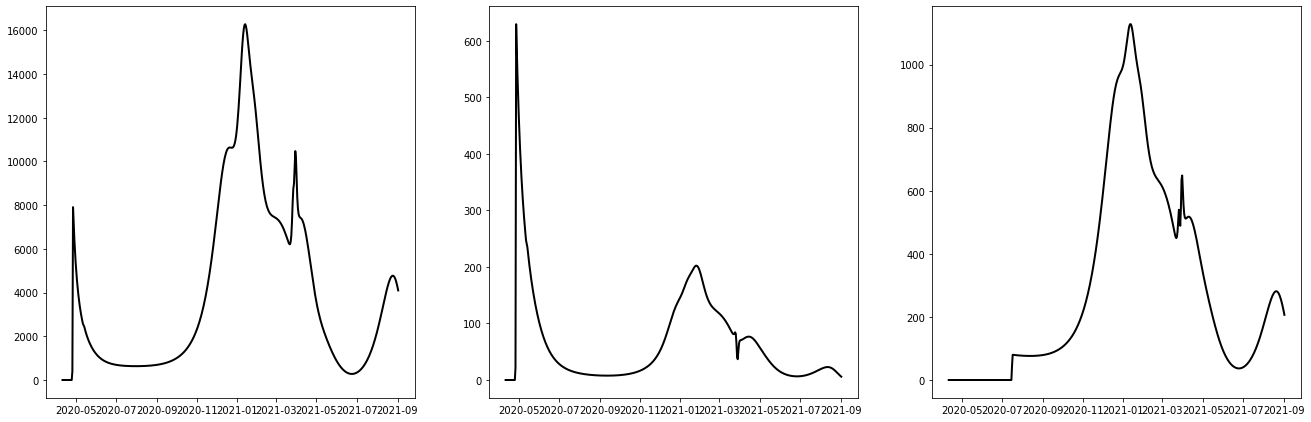

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(22.5, 7.2), sharex=True)

ax[0].plot(incident_df["date"], incident_df["inf_incidence"]    / sf,    lw=2, c="k")
ax[1].plot(incident_df["date"], incident_df["deaths_incidence"] / sf, lw=2, c="k")
ax[2].plot(incident_df["date"], incident_df["hosp_incidence"]   / sf,   lw=2, c="k")


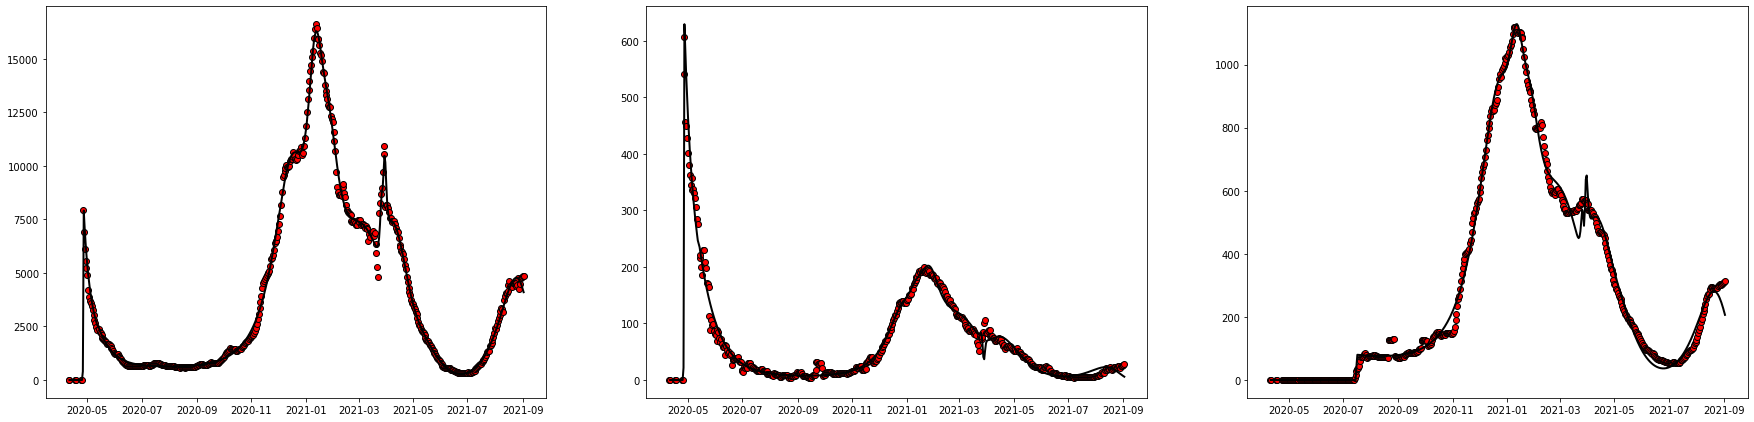

In [16]:

fig, ax = plt.subplots(1, 3, figsize=(30.5, 7.2), sharex=True)

ax[0].plot(incident_df["date"], incident_df["inf_incidence"]    / sf,    lw=2, c="k")
ax[1].plot(incident_df["date"], incident_df["deaths_incidence"] / sf, lw=2, c="k")
ax[2].plot(incident_df["date"], incident_df["hosp_incidence"]   / sf,   lw=2, c="k")

ax[0].scatter(data_df.index.values, data_df["cases_smooth"], facecolor="red", edgecolor="k")
ax[1].scatter(data_df.index.values, data_df["deaths_smooth"], facecolor="red", edgecolor="k")
ax[2].scatter(data_df.index.values, data_df["hospitalizations_smooth"], facecolor="red", edgecolor="k")


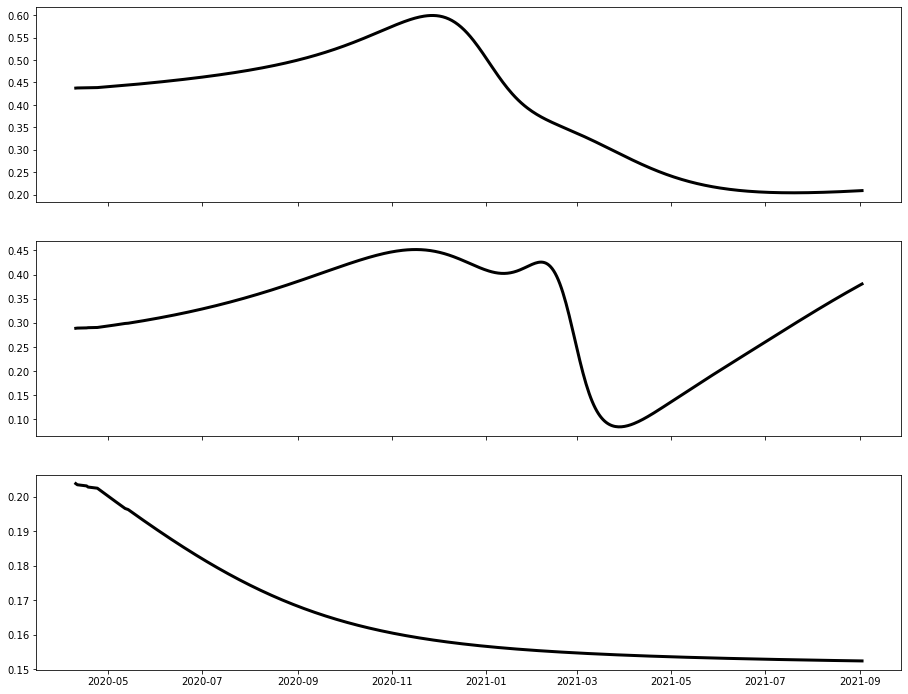

In [17]:

parameters_df["date"] = dates
parameters_df["beta"] = BetaI
parameters_df["p"]    = p
parameters_df["q"]    = q

fig, ax = plt.subplots(3, 1, figsize=(15.5, 12.2), sharex=True)

ax[0].plot(parameters_df["date"], parameters_df["beta"], lw=3, c="k")
ax[1].plot(parameters_df["date"], parameters_df["p"], lw=3, c="k")
ax[2].plot(parameters_df["date"], parameters_df["q"], lw=3, c="k")


In [18]:
def binomial_transition(var, rate, dt=1):
    kb = np.maximum(1.0 - np.exp(-rate * dt), 0)
    num_ind   = np.random.binomial(list(var), kb )
    return num_ind

def dynamic_model(x, beta_t, p_t, q_t, pop=2000):
    S = x[0, :]
    E = x[1, :]
    I = x[2, :]
    J = x[3, :]
    D = x[4, :]
    H = x[5, :]
    R = x[6, :]

    N      = pop
    delta  = 0.6
    gamma  = 1.0 / 6.0
    gammaA = 1.0 / 6.0
    alpha  = 1.0 / 5.2
    eps1   = 0.75
    eps2   = 0.0
    phiD   = 1.0/15.0
    phiR   = 1.0/7.5

    foi = beta_t*(I+eps1*J+eps2*H) / N

    s2e = binomial_transition(S, foi)
    e2i = binomial_transition(E, delta*alpha )
    e2j = binomial_transition(E, ((1-delta)*alpha) )
    i2h = binomial_transition(I, (p_t*gamma) )
    i2r = binomial_transition(I, ((1-p_t)*gamma) )
    h2d = binomial_transition(H, q_t*phiD )
    h2r = binomial_transition(H, ((1-q_t)*phiR) )
    j2r = binomial_transition(J, gammaA )

    S   = S - s2e
    E   = E + s2e - e2i - e2j
    I   = I + e2i - i2r - i2h
    J   = J + e2j -j2r
    D   = D + h2d
    H   = H + i2h - h2d - h2r
    R   = R + j2r  + i2r + h2r

    inc_c = s2e
    inc_d = h2d
    inc_h = i2h

    return np.maximum([S, E, I, J, D, H, R, inc_c, inc_d, inc_h], 0)

In [19]:
p_sim_df = parameters_df.set_index("date")

model_settings                  = {}
model_settings["num_var"]       = 10
model_settings["num_ensembles"] = 300
model_settings["dates"]         = dates

#[S, E, I, J, D, H, R, inc_c, inc_d, inc_h]
x0 = np.expand_dims(np.array([S[0], E[0], np.array([10]), J[0], D[0], H[0], R[0], 0,  0, 0]), -1) * np.ones( (model_settings["num_var"], model_settings["num_ensembles"]) )

x_all      = np.full((len(model_settings["dates"]), model_settings["num_var"], model_settings["num_ensembles"]), np.nan)
x_all[0,:] = x0

for idx_date, date in enumerate(dates[1:]):

    beta_t = p_sim_df.loc[date]["beta"]
    p_t    = p_sim_df.loc[date]["p"]
    q_t    = p_sim_df.loc[date]["q"]

    x_all[idx_date+1, :, :] =  dynamic_model(x_all[idx_date, :, :], beta_t, p_t, q_t, pop=N)

/Users/chaosdonkey06/Dropbox/My Mac (Jaimes-MacBook-Pro.local)/Desktop/Forecasting/frcstng_experiments/pinn_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


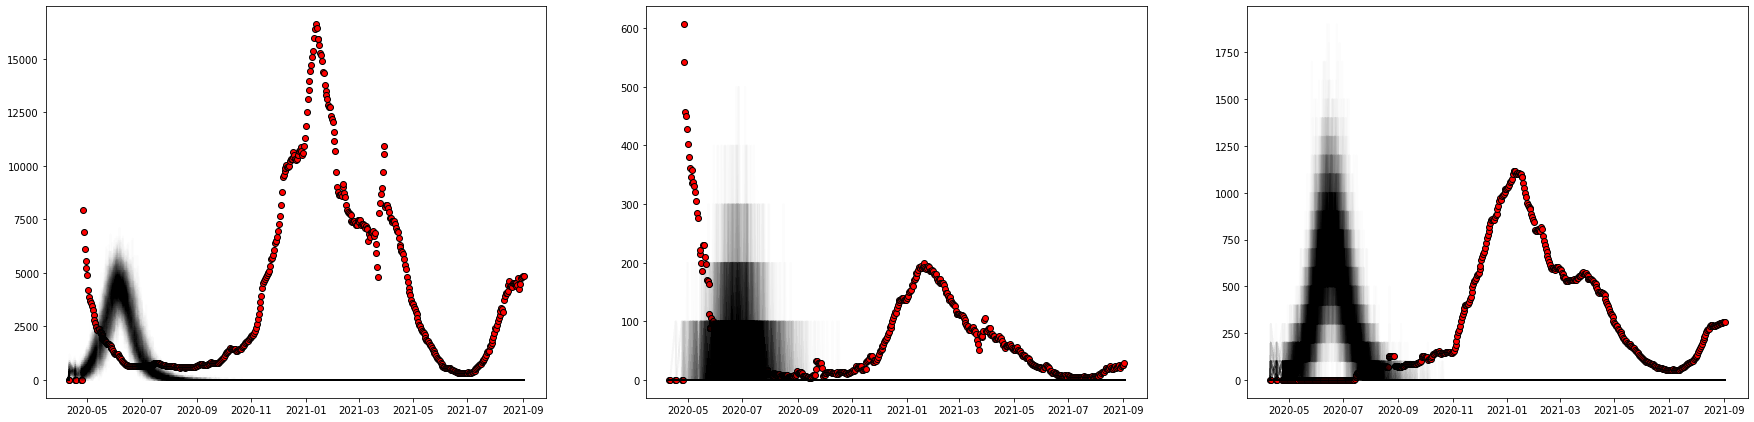

In [28]:

fig, ax = plt.subplots(1, 3, figsize=(30.5, 7.2), sharex=True)

ax[0].plot(model_settings["dates"], x_all[:,-3,:] * 100, lw=2, c="k", alpha=0.01)
ax[1].plot(model_settings["dates"], x_all[:,-2,:] * 100, lw=2, c="k", alpha=0.01)
ax[2].plot(model_settings["dates"], x_all[:,-1,:] * 100, lw=2, c="k", alpha=0.01)

ax[0].scatter(data_df.index.values, data_df["cases_smooth"] , facecolor="red", edgecolor="k")
ax[1].scatter(data_df.index.values, data_df["deaths_smooth"] , facecolor="red", edgecolor="k")
ax[2].scatter(data_df.index.values, data_df["hospitalizations_smooth"], facecolor="red", edgecolor="k")


array([1945.35238839])